## Metropolis Hastings Custom HMC MC Algorithm

In [5]:
from IPython.display import display
import matplotlib.pyplot as plt

from reggae.data_loaders import load_barenco_puma, load_3day_dros, DataHolder
from reggae.mcmc import create_chains, MetropolisHastings
from reggae.models import transcription
from reggae.utilities import get_rbf_dist, exp, mult, discretise

import numpy as np
import pandas as pd
import arviz
from multiprocessing import Pool

np.set_printoptions(formatter={'float': lambda x: "{0:0.5f}".format(x)})
plt.style.use('ggplot')
%matplotlib inline

In [6]:
#df, genes, genes_se, m_observed, f_observed, σ2_m_pre, σ2_f_pre, t = load_barenco_puma()
m_observed, f_observed, σ2_m_pre, σ2_f_pre, t = load_barenco_puma()

# m_observed, f_observed, t = load_3day_dros()

replicate = 0

m_df, m_observed = m_observed 
f_df, f_observed = f_observed

# Shape of m_observed = (replicates, genes, times)
m_observed = m_observed[replicate]
f_observed = np.atleast_2d(f_observed[replicate])
σ2_m_pre = σ2_m_pre[0]
σ2_f_pre = σ2_f_pre[0]

num_genes = m_observed.shape[0]
τ, common_indices = discretise(t)
N_p = τ.shape[0]
N_m = m_observed.shape[1]

data = (m_observed, f_observed)
noise_data = (σ2_m_pre, σ2_f_pre)
time = (t, τ, common_indices)

data = DataHolder(data, noise_data, time)


In [63]:
from collections import namedtuple

import tensorflow as tf
from tensorflow import math as tfm
from tensorflow_probability import bijectors as tfb
from tensorflow_probability import distributions as tfd
import tensorflow_probability as tfp

from reggae.mcmc import MetropolisHastings, Parameter
from reggae.data_loaders import DataHolder
from reggae.utilities import get_rbf_dist, exp, mult, jitter_cholesky

import numpy as np
from scipy.special import expit

f64 = np.float64

class Options():
    def __init__(self, preprocessing_variance=True, tf_mrna_present=True):
        self.preprocessing_variance = preprocessing_variance
        self.tf_mrna_present = tf_mrna_present

class TranscriptionLikelihood():
    def __init__(self, data: DataHolder, options: Options):
        self.options = options
        self.data = data
        self.preprocessing_variance = options.preprocessing_variance
        self.num_genes = data.m_obs.shape[0]

    def predict_m(self, kbar, δbar, w, fbar, w_0):
        # Take relevant parameters out of log-space
        a_j, b_j, d_j, s_j = (np.exp(kbar[:, i]).reshape(-1, 1) for i in range(4))
        δ = np.exp(δbar)
        f_i = np.log(1+np.exp(fbar))
        τ = self.data.τ
        N_p = self.data.τ.shape[0]

        # Calculate p_i vector
        p_i = np.zeros(N_p) # TODO it seems the ODE translation model has params A, S see gpmtfComputeTFODE
        Δ = τ[1]-τ[0]
        sum_term = mult(exp(δ*τ), f_i)
        p_i[1:] = 0.5*Δ*np.cumsum(sum_term[:-1] + sum_term[1:]) # Trapezoid rule
        p_i = mult(exp(-δ*τ), p_i)

        # Calculate m_pred
        integrals = np.zeros((self.num_genes, N_p))
        interactions = w[:, 0][:, None]*np.log(p_i+1e-100) + w_0[:, None]
        G = expit(interactions) # TF Activation Function (sigmoid)
        sum_term = G * exp(d_j*τ)
        integrals[:, 1:] = 0.5*Δ*np.cumsum(sum_term[:, :-1] + sum_term[:, 1:], axis=1) # Trapezoid rule
        exp_dt = exp(-d_j*τ)
        integrals = mult(exp_dt, integrals)
        m_pred = b_j/d_j + mult((a_j-b_j/d_j), exp_dt) + s_j*integrals

        return m_pred

    def genes(self, params, δbar=None,
                     fbar=None, 
                     kbar=None, 
                     w=None,
                     w_0=None,
                     σ2_m=None, return_sq_diff=False):
        '''
        Computes likelihood of the genes.
        If any of the optional args are None, they are replaced by their current value in params.
        '''
        if δbar is None:
            δbar = params.δbar.value
        if fbar is None:
            fbar = params.fbar.value
        if kbar is None:
            kbar = params.kbar.value
        w = params.w.value if w is None else w
        σ2_m = params.σ2_m.value if σ2_m is None else σ2_m

        w_0 = params.w_0.value if w_0 is None else w_0 # TODO no hardcode this!
        m_pred = self.predict_m(kbar, δbar, w, fbar, w_0)

        log_lik = np.zeros(self.num_genes)
        sq_diff = np.square(self.data.m_obs - m_pred[:, self.data.common_indices])
        variance = σ2_m.reshape(-1, 1)
        if self.preprocessing_variance:
            variance = variance + self.data.σ2_m_pre # add PUMA variance
#         print(variance.shape, sq_diff.shape)
        log_lik = -0.5*np.log(2*np.pi*(variance)) - 0.5*sq_diff/variance
        log_lik = np.sum(log_lik, axis=1)
        if return_sq_diff:
            return log_lik, sq_diff
        return log_lik

    def tfs(self, params, fbar, return_sq_diff=False): 
        '''
        Computes log-likelihood of the transcription factors.
        TODO this should be for the i-th TF
        '''
        assert self.options.tf_mrna_present
        if not self.preprocessing_variance:
            σ2_f = params.σ2_f.value
            variance = σ2_f.reshape(-1, 1)
        else:
            variance = self.data.σ2_f_pre
        f_pred = np.log(1+np.exp(fbar))
        f_pred = np.atleast_2d(f_pred)
        sq_diff = np.square(self.data.f_obs - f_pred[:, self.data.common_indices])

        log_lik = -0.5*np.log(2*np.pi*variance) - 0.5*sq_diff/variance
        log_lik = np.sum(log_lik, axis=1)
        if return_sq_diff:
            return log_lik, sq_diff
        return log_lik

TupleParams_pre = namedtuple('TupleParams_pre', ['fbar','δbar','kbar','σ2_m','w','w_0','L','V','σ2_f'])
TupleParams = namedtuple('TupleParams', ['fbar','δbar','kbar','σ2_m','w','w_0','L','V'])

class TranscriptionHMC(MetropolisHastings):
    '''
    Data is a tuple (m, f) of shapes (num, time)
    time is a tuple (t, τ, common_indices)
    '''
    def __init__(self, data: DataHolder, options: Options):
        self.data = data
        min_dist = min(data.t[1:]-data.t[:-1])
        self.N_p = data.τ.shape[0]
        self.N_m = data.t.shape[0]      # Number of observations

        self.num_tfs = data.f_obs.shape[0] # Number of TFs
        self.num_genes = data.m_obs.shape[0]

        self.likelihood = TranscriptionLikelihood(data, options)
        self.options = options
        # Adaptable variances
        a = tf.constant(-0.5, dtype='float64')
        b2 = tf.constant(2., dtype='float64')
        self.h_f = 0.35*tf.ones(self.N_p, dtype='float64')

        # Interaction weights
        w_0 = Parameter('w_0', tfd.Normal(0, 2), np.zeros(self.num_genes), step_size=0.5*tf.ones(self.num_genes, dtype='float64'))
        w_0.proposal_dist=lambda mu, j:tfd.Normal(mu, w_0.step_size[j])
        w = Parameter('w', tfd.Normal(0, 2), 1*np.ones((self.num_genes, self.num_tfs)), step_size=0.5*tf.ones(self.num_genes, dtype='float64'))
        w.proposal_dist=lambda mu, j:tfd.Normal(mu, w.step_size[j]) #) w_j) # At the moment this is the same as w_j0 (see pg.8)
        # Latent function
        fbar = Parameter('fbar', self.fbar_prior, 0.5*np.ones(self.N_p))

        # GP hyperparameters
        def V_log_prob(vstar, l2star):
            new_prob = self.params.fbar.prior(self.params.fbar.value, vstar, l2star)
            new_prob += self.params.V.prior.log_prob(vstar)
            new_prob += self.params.L.prior.log_prob(l2star)
            return tf.reduce_sum(new_prob)
        V = Parameter('V', tfd.InverseGamma(f64(0.01), f64(0.01)), f64(1), step_size=0.1, 
                      fixed=not options.tf_mrna_present, hmc_log_prob=V_log_prob)
        L = Parameter('L', tfd.Uniform(f64(min_dist**2-0.5), f64(data.t[-1]**2)), f64(4), step_size=0.1)
        L.proposal_dist=lambda l2: tfd.TruncatedNormal(l2, L.step_size, low=0, high=100) #l2_i
        self.t_dist = get_rbf_dist(data.τ, self.N_p)

        # Translation kinetic parameters
        def δbar_log_prob(state):
            new_prob = np.sum(self.likelihood.genes(self.params, δbar=state)) + self.params.δbar.prior.log_prob(state)
    #                     old_prob = np.sum(old_m_likelihood) + params.δbar.prior.log_prob(δbar)
            return new_prob

        δbar = Parameter('δbar', tfd.Normal(a, b2), f64(-0.3), step_size=0.3, hmc_log_prob=δbar_log_prob)
        δbar.proposal_dist=lambda mu:tfd.Normal(mu, δbar.step_size)
        # White noise for genes
        σ2_m = Parameter('σ2_m', tfd.InverseGamma(f64(0.01), f64(0.01)), 1e-4*np.ones(self.num_genes), step_size=0.5)
        σ2_m.proposal_dist=lambda mu: tfd.TruncatedNormal(mu, σ2_m.step_size, low=0, high=5)
        # Transcription kinetic parameters
        def constrain_kbar(kbar, gene):
            '''Constrains a given row in kbar'''
#             if gene == 3:
#                 kbar[2] = np.log(0.8)
#                 kbar[3] = np.log(1.0)
            kbar[kbar < -10] = -10
            kbar[kbar > 3] = 3
            return kbar
        kbar_initial = -0.1*np.float64(np.c_[
            np.ones(self.num_genes), # a_j
            np.ones(self.num_genes), # b_j
            np.ones(self.num_genes), # d_j
            np.ones(self.num_genes)  # s_j
        ])
        def kbar_log_prob(kstar):
            new_prob = self.likelihood.genes(self.params, kbar=kstar)#[j]
            new_prob +=tf.reduce_sum(self.params.kbar.prior.log_prob(kstar))
            return new_prob

        for j, k in enumerate(kbar_initial):
            kbar_initial[j] = constrain_kbar(k, j)
        kbar = Parameter('kbar',
                         tfd.Normal(a, b2), 
                         kbar_initial,
                         constraint=constrain_kbar, 
                         step_size=0.1,
                         hmc_log_prob=kbar_log_prob)
        kbar.proposal_dist=lambda mu: tfd.MultivariateNormalDiag(mu, kbar.step_size)
        
        if not options.preprocessing_variance:
            σ2_f = Parameter('σ2_f', tfd.InverseGamma(f64(0.01), f64(0.01)), 1e-4*np.ones(self.num_tfs), step_size=tf.constant(0.5, dtype='float64'))
            super().__init__(TupleParams_pre(fbar, δbar, kbar, σ2_m, w, w_0, L, V, σ2_f))
        else:
            super().__init__(TupleParams(fbar, δbar, kbar, σ2_m, w, w_0, L, V))

    def fbar_prior_params(self, v, l2):
    #     print('vl2', v, l2)
        jitter = tf.linalg.diag(1e-5 * np.ones(self.N_p))
        K = mult(v, exp(-np.square(self.t_dist)/(2*l2))) + jitter
        m = np.zeros(self.N_p)
        return m, K

    def fbar_prior(self, fbar, v, l2):
        m, K = self.fbar_prior_params(v, l2)
    
        try:
            return tfd.MultivariateNormalFullCovariance(m, K).log_prob(fbar)
        except:
            jitter = tf.linalg.diag(1e-4 * np.ones(self.N_p))
            try:
                return np.float64(tfd.MultivariateNormalFullCovariance(m, K+jitter).log_prob(fbar))
            except:
                return 0


    def iterate(self):
        params = self.params
        # Compute likelihood for comparison
        old_m_likelihood, sq_diff_m  = self.likelihood.genes(params, return_sq_diff=True)
        old_f_likelihood = 0
        if self.options.tf_mrna_present:
            old_f_likelihood, sq_diff_f  = self.likelihood.tfs(params, params.fbar.value, return_sq_diff=True)
        
        # Untransformed tf mRNA vectors F (Step 1)
        fbar = params.fbar.value
        for i in range(self.num_tfs):
            # Gibbs step
            z_i = tf.reshape(tfd.MultivariateNormalDiag(fbar, self.h_f).sample(), (1, -1))
            # MH
            m, K = self.fbar_prior_params(params.V.value, params.L.value)
            invKsigmaK = tf.matmul(tf.linalg.inv(K+tf.linalg.diag(self.h_f)), K) # (C_i + hI)C_i
            L = jitter_cholesky(K-tf.matmul(K, invKsigmaK))
            c_mu = tf.matmul(z_i, invKsigmaK)
            fstar = tf.matmul(tf.random.normal((1, L.shape[0]), dtype='float64'), L) + c_mu
            fstar = tf.reshape(fstar, (-1, ))
            new_m_likelihood = self.likelihood.genes(params, fbar=fstar)
            new_f_likelihood = 0 
            if self.options.tf_mrna_present:
                new_f_likelihood = self.likelihood.tfs(params, fstar)
            new_prob = np.sum(new_m_likelihood) + new_f_likelihood
            old_prob = np.sum(old_m_likelihood) + old_f_likelihood
            if self.is_accepted(new_prob, old_prob):
                params.fbar.value = fstar
                old_m_likelihood = new_m_likelihood
                old_f_likelihood = new_f_likelihood
                self.acceptance_rates['fbar'] += 1/self.num_tfs


        if self.options.tf_mrna_present: # (Step 2)
            # Log of translation ODE degradation rates
            δbar = params.δbar.value
            for i in range(self.num_tfs):# TODO make for self.num_tfs > 1
                # Proposal distribution
#                 δstar = params.δbar.propose(δbar) # δstar is in log-space, i.e. δstar = δbar*
                
                #adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(hmc, num_adaptation_steps=2)

                samples, is_accepted = tfp.mcmc.sample_chain(
                    num_results=1,
                    num_burnin_steps=0,
                    current_state=δbar,
                    kernel=params.δbar.kernel,
                    trace_fn=lambda _, pkr: pkr.is_accepted)

#                 print('samples', δbar, samples, is_accepted)
    #             print(δstar, params.δbar.prior.log_prob(δstar))
    #             print(new_prob, old_prob)
                if is_accepted[0]:
                    params.δbar.value = samples[0] #δstar
                    self.acceptance_rates['δbar'] += 1/self.num_tfs

        # Log of transcription ODE kinetic params (Step 3)
        kbar = params.kbar.value
        kstar = kbar.copy()
        samples, is_accepted = tfp.mcmc.sample_chain(
            num_results=1,
            num_burnin_steps=0,
            current_state=kbar,
            kernel=params.kbar.kernel,
            trace_fn=lambda _, pkr: pkr.is_accepted)
#         print(samples[0])

        for j in range(self.num_genes):
            if is_accepted[0][j]:
                params.kbar.value[j] = samples[0][j]
                self.acceptance_rates['kbar'] += 1/self.num_genes

#             sample = params.kbar.propose(kstar[j])
#             sample = params.kbar.constrain(sample, j)
#             kstar[j] = sample
            

#             new_prob = self.likelihood.genes(params, kbar=kstar)[j] + sum(params.kbar.prior.log_prob(sample))
#             old_prob = old_m_likelihood[j] + sum(params.kbar.prior.log_prob(kbar[j]))
#             if self.is_accepted(new_prob, old_prob):
#                 test = params.kbar.value
#                 test[j]=sample
#                 params.kbar.value = test
#                 self.acceptance_rates['kbar'] += 1/self.num_genes
#             else:
#                 kstar[j] = params.kbar.value[j]


        # Interaction weights and biases (note: should work for self.num_tfs > 1) (Step 4)
        w = params.w.value
        w_0 = params.w_0.value
        wstar = w.copy()
        w_0star = w_0.copy()
        for j in range(self.num_genes):
            sample_0 = params.w_0.propose(w_0[j], j)
            sample = params.w.propose(wstar[j], j)
            wstar[j] = sample
            w_0star[j] = sample_0
            new_prob = self.likelihood.genes(params, w=wstar, w_0=w_0star)[j] + sum(params.w.prior.log_prob(sample)) + params.w_0.prior.log_prob(sample_0)
            old_prob = old_m_likelihood[j] + sum(params.w.prior.log_prob(w[j,:])) + params.w_0.prior.log_prob(w_0[j])
            if self.is_accepted(new_prob, old_prob):
                params.w.value[j] = sample
                params.w_0.value[j] = sample_0
                self.acceptance_rates['w'] += 1/self.num_genes
                self.acceptance_rates['w_0'] += 1/self.num_genes
            else:
                wstar[j] = params.w.value[j]

        # Noise variances
        if self.options.preprocessing_variance:
            σ2_m = params.σ2_m.value
            σ2_mstar = σ2_m.copy()
            for j in range(self.num_genes):
                sample = params.σ2_m.propose(σ2_m[j])
                σ2_mstar[j] = sample
                old_q = params.σ2_m.proposal_dist(σ2_mstar[j]).log_prob(σ2_m[j])
                new_prob = self.likelihood.genes(params, σ2_m=σ2_mstar)[j] +params.σ2_m.prior.log_prob(σ2_mstar[j])
                
                new_q = params.σ2_m.proposal_dist(σ2_m[j]).log_prob(σ2_mstar[j])
                old_prob = self.likelihood.genes(params, σ2_m=σ2_m)[j] + params.σ2_m.prior.log_prob(σ2_m[j])
                    
                if self.is_accepted(new_prob + old_q, old_prob + new_q):
                    params.σ2_m.value[j] = sample
                    self.acceptance_rates['σ2_m'] += 1/self.num_genes
                else:
                    σ2_mstar[j] = σ2_m[j]
        else: # Use Gibbs sampling
            # Prior parameters
            α = params.σ2_m.prior.concentration
            β = params.σ2_m.prior.scale
            # Conditional posterior of inv gamma parameters:
            α_post = α + 0.5*self.N_m
            β_post = β + 0.5*np.sum(sq_diff_m)
            # print(α.shape, sq_diff.shape)
            # print('val', β_post.shape, params.σ2_m.value)
            params.σ2_m.value = np.repeat(tfd.InverseGamma(α_post, β_post).sample(), self.num_genes)
            self.acceptance_rates['σ2_m'] += 1
            
            if self.options.tf_mrna_present: # (Step 5)
                # Prior parameters
                α = params.σ2_f.prior.concentration
                β = params.σ2_f.prior.scale
                # Conditional posterior of inv gamma parameters:
                α_post = α + 0.5*self.N_m
                β_post = β + 0.5*np.sum(sq_diff_f)
                # print(α.shape, sq_diff.shape)
                # print('val', β_post.shape, params.σ2_m.value)
                params.σ2_f.value = np.repeat(tfd.InverseGamma(α_post, β_post).sample(), self.num_tfs)
                self.acceptance_rates['σ2_f'] += 1

            # print('val', params.σ2_m.value)
        # Length scales and variances of GP kernels
        l2 = params.L.value
        v = params.V.value
        for i in range(self.num_tfs):
            # Proposal distributions
            # Acceptance probabilities            
            
            samples, is_accepted = tfp.mcmc.sample_chain(
                num_results=1,
                num_burnin_steps=0,
                current_state=[v, l2],
                kernel=params.V.kernel,
                trace_fn=lambda _, pkr: pkr.is_accepted)

            if is_accepted[0]:
                params.V.value = np.squeeze(samples[0]) #vstar
                params.L.value = np.squeeze(samples[1])
        
#             if accepted:
#                 params.L.value = l2star
                self.acceptance_rates['V'] += 1/self.num_tfs
                self.acceptance_rates['L'] += 1/self.num_tfs

    @staticmethod
    def initialise_from_state(args, state):
        model = TranscriptionMCMC(*args)
        model.acceptance_rates = state.acceptance_rates
        model.samples = state.samples
        return model

    def predict_m(self, kbar, δbar, w, fbar, w_0):
        return self.likelihood.predict_m(kbar, δbar, w, fbar, w_0)

    def predict_m_with_current(self):
        return self.likelihood.predict_m(self.params.kbar.value, 
                                         self.params.δbar.value, 
                                         self.params.w.value, 
                                         self.params.fbar.value,
                                         self.params.w_0.value)



In [64]:
opt = Options(preprocessing_variance=True, tf_mrna_present=True)
model = TranscriptionHMC(data, opt)


In [65]:
T = 1500
model.sample(T, 1, 0, 1)

print(model.acceptance_rates)
samples = model.samples
acceptance_rates = model.acceptance_rates


----- Metropolis Begins -----


IntProgress(value=0, description='Running', max=1500)

----- Finished -----
{'fbar': 0.5413333333333333, 'δbar': 0.194, 'kbar': 0.4554666666666789, 'σ2_m': 0.39066666666666416, 'w': 0.3461333333333207, 'w_0': 0.3461333333333207, 'L': 0.048666666666666664, 'V': 0.048666666666666664}


In [52]:
T = 1000
store_every = 1
burn_in = 0
report_every = 20
num_chains = 4
tune_every = 50

job = create_chains(
    transcription.TranscriptionMCMC, 
    [data, opt], 
    {
        'T': T, 
        'store_every': store_every, 
        'burn_in': burn_in,
        'report_every': report_every,
        'tune_every':tune_every
    }, 
    num_chains=num_chains)

    
print('Done')

Done


## Convergence Plots

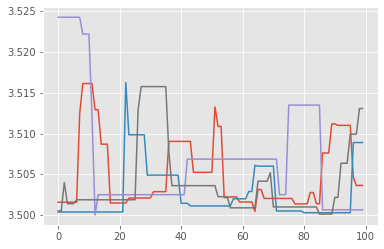

In [53]:
keys = job[0].acceptance_rates.keys()

variables = {key : np.empty((0, T, *job[0].samples[key].get().shape[1:])) for key in keys}

for res in job:
    for key in keys:
        variables[key] = np.append(variables[key], np.expand_dims(res.samples[key].get(), 0), axis=0)

plt.plot(variables['L'][:,-100:].T)

mixes = {key: arviz.convert_to_inference_data(variables[key]) for key in keys}

#### Rhat
Rhat is the ratio of posterior variance and within-chain variance. If the ratio exceeds 1.1 then we consider the chains have not mixed well. As the between-chain variance tends to the within-chain then R tends to 1.

In [54]:
Rhat = arviz.rhat(mixes['fbar'])

Rhats = np.array([np.mean(arviz.rhat(mixes[key]).x.values) for key in keys])

rhat_df = pd.DataFrame([[*Rhats], [*(Rhats < 1.1)]], columns=keys)

display(rhat_df)

C:\Users\Jacob\AppData\Local\Programs\Python\Python37\lib\site-packages\arviz\stats\diagnostics.py:590: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
C:\Users\Jacob\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less
  """


,fbar,δbar,kbar,σ2_m,w,w_0,L,V
0,1.16407,NaN,1.24568,1.16175,1.10162,1.09218,1.04352,NaN
1,False,False,False,False,False,True,True,False


#### Rank plots

Rank plots are histograms of the ranked posterior draws (ranked over all
    chains) plotted separately for each chain.
    If all of the chains are targeting the same posterior, we expect the ranks in each chain to be
    uniform, whereas if one chain has a different location or scale parameter, this will be
    reflected in the deviation from uniformity. If rank plots of all chains look similar, this
    indicates good mixing of the chains.

Rank-normalization, folding, and localization: An improved R-hat
    for assessing convergence of MCMC. arXiv preprint https://arxiv.org/abs/1903.08008

In [ ]:
arviz.plot_rank(L_mix)

#### Effective sample sizes

Plot quantile, local or evolution of effective sample sizes (ESS).

In [ ]:
arviz.plot_ess(L_mix)

#### Monte-Carlo Standard Error

In [ ]:
arviz.plot_mcse(L_mix)


#### Parallel Plot
Plot parallel coordinates plot showing posterior points with and without divergences.

Described by https://arxiv.org/abs/1709.01449, suggested by Ari Hartikainen


In [ ]:
arviz.plot_parallel(azl)


Step size is standard dev, too small means it takes long time to reach high density areas. too long means we reject many of samples

## Plots

In [55]:
samples = job[0].samples
acceptance_rates = job[0].acceptance_rates

model = transcription.TranscriptionMCMC.initialise_from_state([data, opt], job[0])

In [31]:
# Begin MCMC
T = 1000
model.sample(T, store_every, burn_in, report_every)

print(model.acceptance_rates)
samples = model.samples

----- Metropolis Begins -----


IntProgress(value=0, description='Running', max=1000)

----- Finished -----
{'fbar': 0.484, 'δbar': 0.299, 'kbar': 0.3283999999999899, 'σ2_m': 0.29739999999999167, 'w': 0.2597999999999938, 'w_0': 0.2597999999999938, 'L': 0.196, 'V': 0.196}


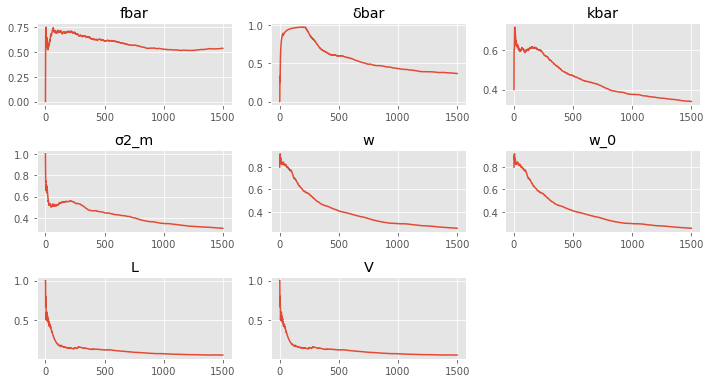

In [38]:
# samples = transcription_model.samples
acceptance_rates = model.acceptance_rates
plt.figure(figsize=(10,14))
parameter_names = acceptance_rates.keys()
acc_rates = samples['acc_rates']

for i, name in enumerate(parameter_names):
    plt.subplot(len(parameter_names), 3, i+1)
    deltas = acc_rates[i]
    plt.plot(deltas)
    plt.title(name)
plt.tight_layout()

Text(0.5, 1.0, 'Interaction bias')

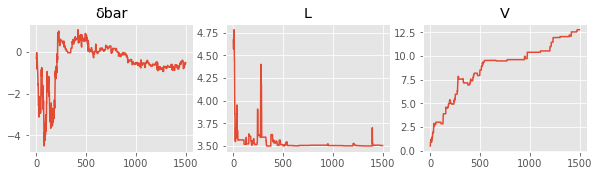

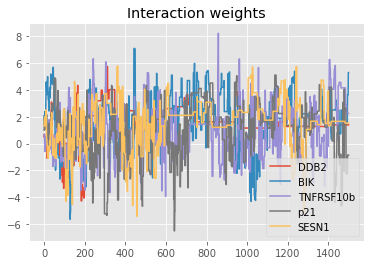

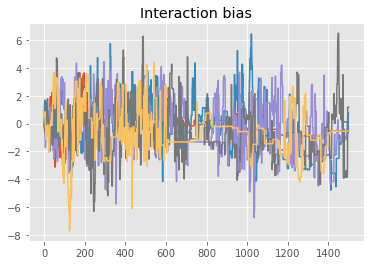

In [39]:
# Plot decay
plt.figure(figsize=(10, 8))
for i, param in enumerate(['δbar', 'L', 'V']):
    ax = plt.subplot(331+i)
    plt.plot(samples[param].get())
    ax.set_title(param)
#'σ', 'w']):

plt.figure()
for j in range(num_genes):
    plt.plot(samples['w'].get()[:, j], label=m_df.index[j])
plt.legend()
plt.title('Interaction weights')

plt.figure()
for j in range(num_genes):
    plt.plot(samples['w_0'].get()[:,j])
plt.title('Interaction bias')


### Plot transcription ODE kinetic params


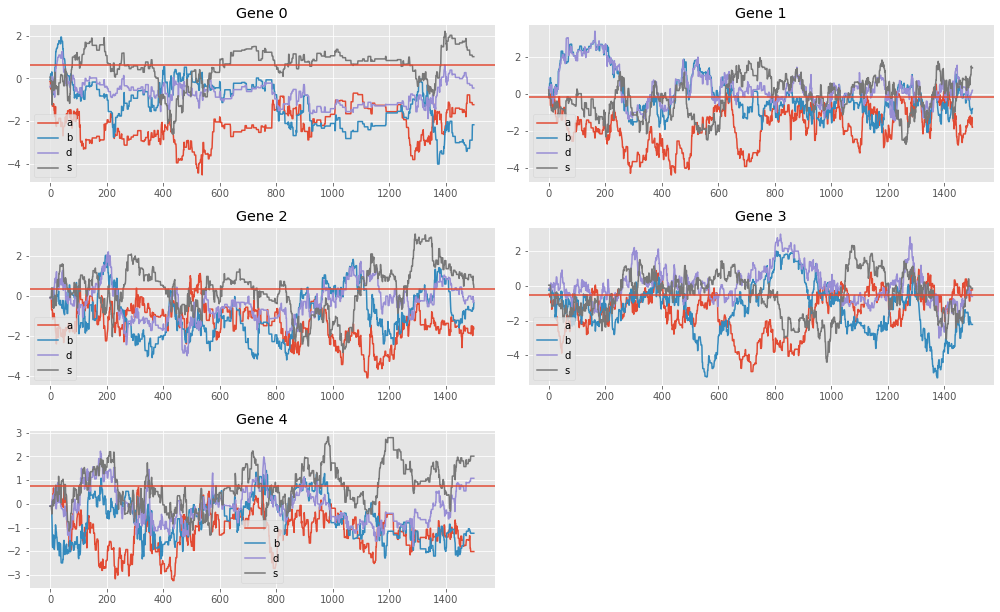

In [66]:
plt.figure(figsize=(14, 14))
plt.title('Transcription ODE kinetic parameters')
labels = ['a', 'b', 'd', 's']
for j in range(num_genes):
    ax = plt.subplot(num_genes, 2, j+1)
    k_param = samples['kbar'].get()[:, j]
#     print(k_param)
    
    for k in range(4):
        plt.plot(k_param[-20000:, k], label=labels[k])
    plt.axhline(np.mean(k_param[-20000:, 3]))
    plt.legend()
    ax.set_title(f'Gene {j}')

plt.tight_layout()


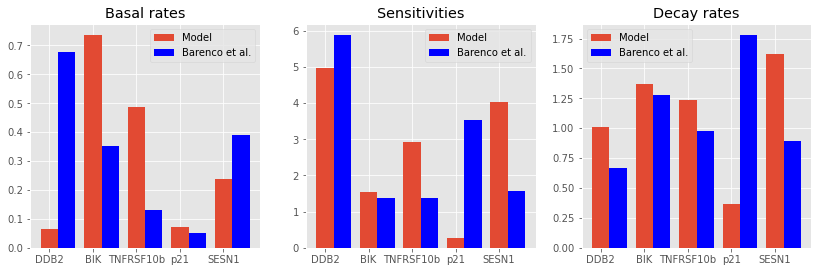

In [67]:
plot_barenco = True
def plot_kinetics(kbar, plot_barenco=False):
    plt.figure(figsize=(14, 14))
    k_latest = np.exp(np.mean(kbar[-100:], axis=0))
    B = k_latest[:,1]
    D = k_latest[:,2]
    S = k_latest[:,3]
    data = [B, S, D]
    barenco_data = [None, None, None]

    if plot_barenco:
        # From Martino paper ... do a rough rescaling so that the scales match.
        B_barenco = np.array([2.6, 1.5, 0.5, 0.2, 1.35])[[0, 4, 2, 3, 1]]
        B_barenco = B_barenco/np.mean(B_barenco)*np.mean(B)
        S_barenco = (np.array([3, 0.8, 0.7, 1.8, 0.7])/1.8)[[0, 4, 2, 3, 1]]
        S_barenco = S_barenco/np.mean(S_barenco)*np.mean(S)
        D_barenco = (np.array([1.2, 1.6, 1.75, 3.2, 2.3])*0.8/3.2)[[0, 4, 2, 3, 1]]
        D_barenco = D_barenco/np.mean(D_barenco)*np.mean(D)
        barenco_data = [B_barenco, S_barenco, D_barenco]

    labels = ['Basal rates', 'Sensitivities', 'Decay rates']

    plotnum = 331
    for A, B, label in zip(data, barenco_data, labels):
        plt.subplot(plotnum)
        plotnum+=1
        plt.bar(np.arange(num_genes)-0.2, A, width=0.4, tick_label=m_df.index, label='Model')
        if B is not None:
            plt.bar(np.arange(num_genes)+0.2, B, width=0.4, color='blue', align='center', label='Barenco et al.')
        plt.title(label)
        plt.legend()

kbar = samples['kbar'].get()
plot_kinetics(kbar, plot_barenco)

[ 0 11 22 33 44 55 66]


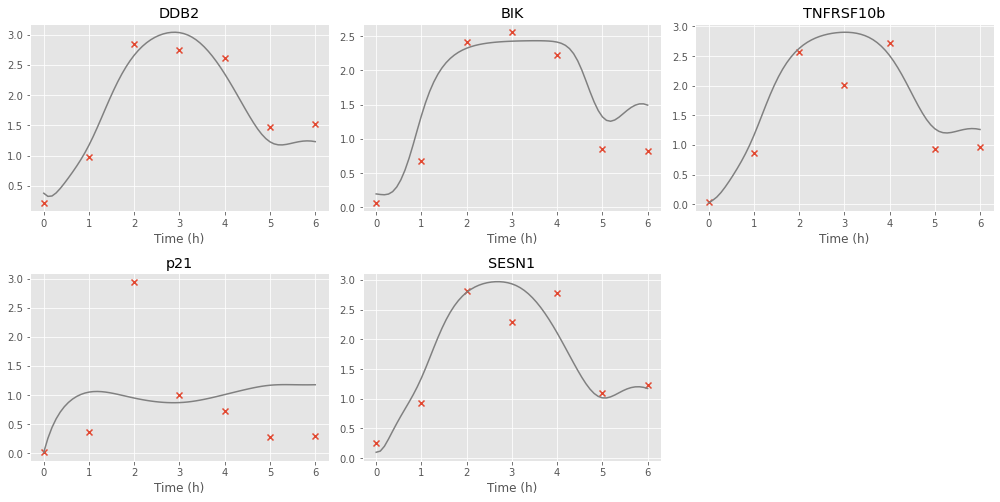

In [42]:
# Plot genes
plt.figure(figsize=(14, 17))
kbar = samples['kbar'].get()[-1]
δbar = samples['δbar'].get()[-1]
w = samples['w'].get()[-1]
fbar = samples['fbar'].get()[-1]
w_0 = samples['w_0'].get()[-1]
m_pred = model.predict_m(kbar, δbar, w, fbar, w_0)
print(np.arange(N_p)[common_indices])
for j in range(num_genes):
    ax = plt.subplot(531+j)
    plt.title(m_df.index[j])
    plt.scatter(common_indices, m_observed[j], marker='x')
    # plt.errorbar([n*10+n for n in range(7)], Y[j], 2*np.sqrt(Y_var[j]), fmt='none', capsize=5)
    plt.plot(m_pred[j,:], color='grey')
    plt.xticks(np.arange(N_p)[common_indices])
    ax.set_xticklabels(np.arange(t[-1]))
    plt.xlabel('Time (h)')
    
plt.tight_layout()

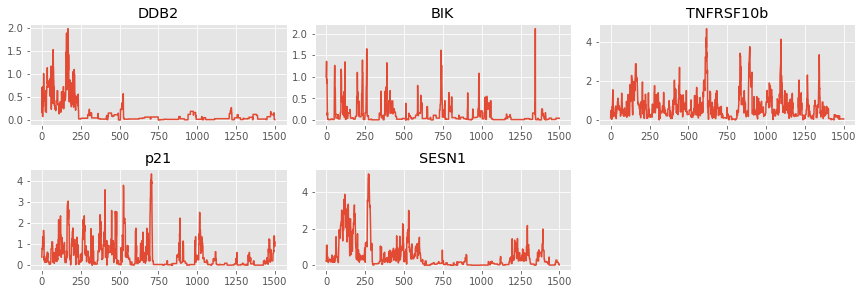

In [43]:
plt.figure(figsize=(12, 10))
plt.title('Noise variances')
for i, j in enumerate(range(num_genes)):
    ax = plt.subplot(num_genes, num_genes-2, i+1)
    plt.title(m_df.index[j])
    plt.plot(samples['σ2_m'].get()[:,j])
    
plt.tight_layout()

In [44]:
def scaled_barenco_data(f):
    scale_pred = np.sqrt(np.var(f))
    barencof = np.array([[0.0, 200.52011, 355.5216125, 205.7574913, 135.0911372, 145.1080997, 130.7046969],
                         [0.0, 184.0994134, 308.47592, 232.1775328, 153.6595161, 85.7272235, 168.0910562],
                         [0.0, 230.2262511, 337.5994811, 276.941654, 164.5044287, 127.8653452, 173.6112139]])

    barencof = barencof[0]/(np.sqrt(np.var(barencof[0])))*scale_pred
    # measured_p53 = df[df.index.isin(['211300_s_at', '201746_at'])]
    # measured_p53 = measured_p53.mean(0)
    # measured_p53 = measured_p53*scale_pred
    measured_p53 = 0
    
    return barencof, measured_p53

def plot_f(f):
    fig = plt.figure(figsize=(13, 7))

    barencof = scaled_barenco_data(f)
    lb = len(barencof)
    plt.plot(np.arange(N_p), f, color='grey')
    plt.scatter(np.arange(0, N_p)[common_indices], barencof, marker='x')
    plt.xticks(np.arange(N_p)[common_indices])
    fig.axes[0].set_xticklabels(np.arange(N_m)*2)
    plt.xlabel('Time (h)')
    


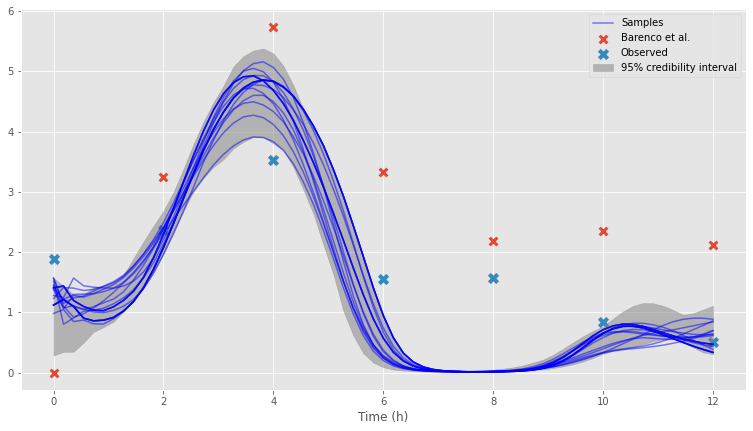

In [45]:
fig = plt.figure(figsize=(13, 7))
f_samples = np.log(1+np.exp(np.array(samples['fbar'].get()[-50:])))
if 'σ2_f' in model.params._fields:
    σ2_f = model.params.σ2_f.value
    plt.errorbar(τ[common_indices], f_observed[0], 2*np.sqrt(σ2_f[0]), 
                 fmt='none', capsize=5, color='blue')
else:
    σ2_f = σ2_f_pre
    
bounds = arviz.hpd(f_samples, credible_interval=0.95)
for i in range(1,20):
    f_i = f_samples[-i]
#     plt.plot(f_i)
#     f_i[0] = 0
    kwargs = {}
    if i == 1:
        kwargs = {'label':'Samples'}
    plt.plot(τ, f_i, c='blue', alpha=0.5, **kwargs)

if plot_barenco:
    barenco_f, _ = scaled_barenco_data(np.mean(f_samples[-10:], axis=0))
    plt.scatter(τ[common_indices], barenco_f, marker='x', s=60, linewidth=3, label='Barenco et al.')

plt.scatter(τ[common_indices], f_observed[0], marker='x', s=70, linewidth=4, label='Observed')

plt.fill_between(τ, bounds[:, 0], bounds[:, 1], color='grey', alpha=0.5, label='95% credibility interval')
plt.xticks(np.arange(N_m)*2)
fig.axes[0].set_xticklabels(t)
plt.xlabel('Time (h)')
plt.legend();

In [27]:
np.linspace(0,12,100)

array([0.00000, 0.12121, 0.24242, 0.36364, 0.48485, 0.60606, 0.72727,
       0.84848, 0.96970, 1.09091, 1.21212, 1.33333, 1.45455, 1.57576,
       1.69697, 1.81818, 1.93939, 2.06061, 2.18182, 2.30303, 2.42424,
       2.54545, 2.66667, 2.78788, 2.90909, 3.03030, 3.15152, 3.27273,
       3.39394, 3.51515, 3.63636, 3.75758, 3.87879, 4.00000, 4.12121,
       4.24242, 4.36364, 4.48485, 4.60606, 4.72727, 4.84848, 4.96970,
       5.09091, 5.21212, 5.33333, 5.45455, 5.57576, 5.69697, 5.81818,
       5.93939, 6.06061, 6.18182, 6.30303, 6.42424, 6.54545, 6.66667,
       6.78788, 6.90909, 7.03030, 7.15152, 7.27273, 7.39394, 7.51515,
       7.63636, 7.75758, 7.87879, 8.00000, 8.12121, 8.24242, 8.36364,
       8.48485, 8.60606, 8.72727, 8.84848, 8.96970, 9.09091, 9.21212,
       9.33333, 9.45455, 9.57576, 9.69697, 9.81818, 9.93939, 10.06061,
       10.18182, 10.30303, 10.42424, 10.54545, 10.66667, 10.78788,
       10.90909, 11.03030, 11.15152, 11.27273, 11.39394, 11.51515,
       11.63636, 11.75758